In [1]:
import matplotlib.pyplot as plt #plot import
import matplotlib.colors  #color import
import numpy as np  #importing numpy
from PIL import Image #importing PIL to read all kind of images
from skimage import data #package to image processing & using natively Numpy arrays as image objects
import scipy #scientific python
from ipywidgets import interact, fixed, FloatSlider, IntSlider, FloatRangeSlider,Label
from scipy.ndimage import convolve
import math

## Reading the cameraman image and displaying it as a gray scale image

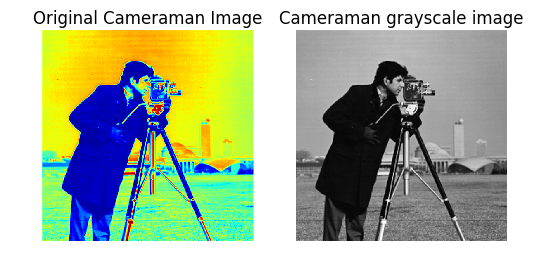

In [2]:
plt.rcParams['image.interpolation'] = 'none'

def displaying_image_as_grayscale(cameraman_image):
    fig,axes_array=plt.subplots(1, 2)  #creating 2 subplots to print original and gray image
    image_plot = axes_array[0].imshow(cameraman_image) 
    axes_array[0].axis('off')
    axes_array[0].set(title='Original Cameraman Image')   #title
    image_plot = axes_array[1].imshow( cameraman_image,cmap=plt.cm.gray)  #showing original image as grayscale image
    axes_array[1].axis('off')
    axes_array[1].set(title='Cameraman grayscale image')   #title
    plt.show()


cameraman_image = data.camera()/255. #converting image to numpy array
displaying_image_as_grayscale(cameraman_image);

## Gaussian smoothing operator to the image and display the smoothed image.

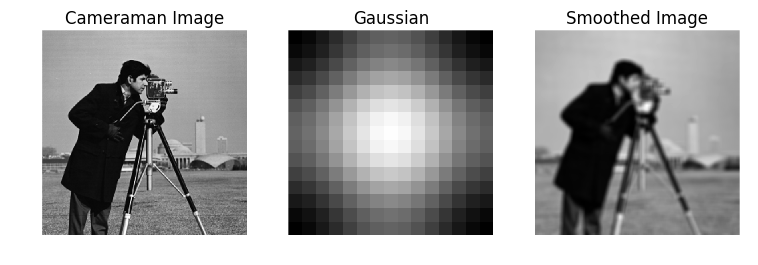

In [3]:
def gaussian_kernel(kernel_size,sigma):
    #Make sure the kernel size is odd
    #kernel_size=kernel_size if kernel_size%2 else kernel_size+1
    temp_image = np.zeros((kernel_size, kernel_size))
    
    #set element at the middle to one
    temp_image[int(kernel_size/2), int(kernel_size/2)] = 1
    
    return scipy.ndimage.filters.gaussian_filter(temp_image,sigma=sigma, order=0, output=None, mode='reflect', cval=0.0)
    
def Smoothing_image_using_gaussian(cameraman_image,kernel_size,sigma):
    gaussian_kernel_template = gaussian_kernel(kernel_size,sigma)
    return scipy.ndimage.convolve(cameraman_image,gaussian_kernel_template)

def displaying_gaussian_smooth_image(cameraman_image,kernel_size,sigma):

    gaussian_kernel_template = gaussian_kernel(kernel_size,sigma)
    global smoothed_image 
    smoothed_image = Smoothing_image_using_gaussian(cameraman_image,kernel_size,sigma)
    
    fig,axes_array=plt.subplots(1, 3)
    fig.set_size_inches(9,3)
    image_plot = axes_array[0].imshow(cameraman_image,cmap=plt.cm.gray) 
    axes_array[0].axis('off')
    axes_array[0].set(title='Cameraman Image')   #title
    image_plot = axes_array[1].imshow( gaussian_kernel_template,cmap=plt.cm.gray)
    axes_array[1].axis('off')
    axes_array[1].set(title='Gaussian')   #title
    image_plot = axes_array[2].imshow( smoothed_image,cmap=plt.cm.gray)
    axes_array[2].axis('off')
    axes_array[2].set(title='Smoothed Image')   #title
    plt.show()
    
    
interact(displaying_gaussian_smooth_image,cameraman_image=fixed(cameraman_image),
              kernel_size=IntSlider(min=3, max=50, step=2,value=7),
            sigma=FloatSlider(min=0., max=20., step=0.5,value=5),continuous_update=False);

# Task 2
## Sobel operator to the smoothed image and display the magnitude and the direction of the edges as two separate images.

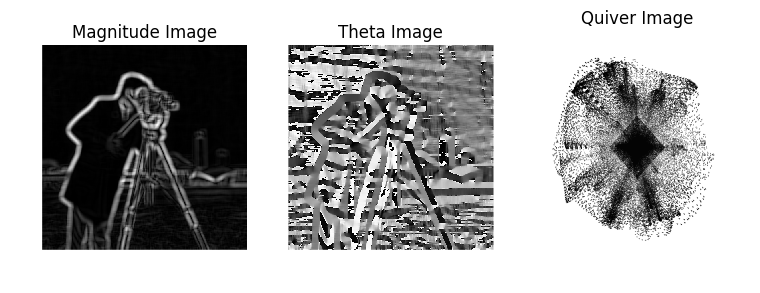

In [4]:
def sob_op(smoothed_image):
    smooth_image_for_edge=smoothed_image
    horizontal_kernel = np.array([[ 1.,  2,  1],[ 0,  0,  0],[-1,-2,-1]])
    vertical_kernel = np.array([[ -1.,  0,  1],[ -2,  0,  2],[-1,0,1]])
     # Normalize the kernels
    kernel_sum=abs(np.sum(horizontal_kernel))
    horizontal_kernel= horizontal_kernel/kernel_sum if kernel_sum else horizontal_kernel
    kernel_sum=abs(np.sum(vertical_kernel))
    vertical_kernel= vertical_kernel/kernel_sum if kernel_sum else vertical_kernel
    #applying sobel horizontal and vertical operator
    horizontal_edge_image = scipy.ndimage.convolve(smooth_image_for_edge , horizontal_kernel)
    vertical_edge_image = scipy.ndimage.convolve(smooth_image_for_edge , vertical_kernel)
    #combining two images to get magnitude
    global magnitude_image
    magnitude_image = np.absolute(horizontal_edge_image) + np.absolute(vertical_edge_image)
    global theta
    theta = scipy.arctan2(horizontal_edge_image, vertical_edge_image)
    horizontal_component = magnitude_image * np.cos(theta)
    vertical_component = magnitude_image * np.sin(theta)
    
    fig,axes_array=plt.subplots(1, 3)
    fig.set_size_inches(9,3)
    
    image_plot = axes_array[0].imshow(magnitude_image,cmap=plt.cm.gray) 
    axes_array[0].axis('off')
    axes_array[0].set(title='Magnitude Image')   #title
    
    image_plot = axes_array[1].imshow(theta,cmap=plt.cm.gray) 
    axes_array[1].axis('off')
    axes_array[1].set(title='Theta Image')   #title
    
    image_plot = axes_array[2].quiver(horizontal_edge_image,vertical_edge_image,horizontal_component,vertical_component)
    axes_array[2].axis('off')
    axes_array[2].set(title='Quiver Image')   #title
    plt.show()
    
sob_op(smoothed_image)

# Task 3
## non-maximum suppression algorithm, result as a gray scale image

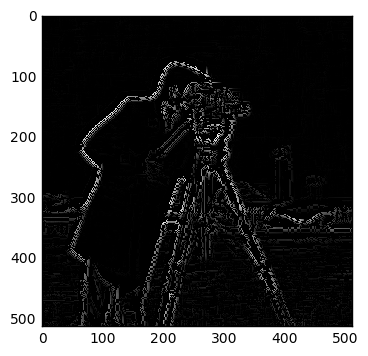

In [5]:
(width,height)=theta.shape
#For each image pixel in the direction matrix, 
#if corresponding pixel of the magnitude image is less than its diagonals, vertical or horizontal pixels 
#we make that pixel 0.
theta = np.rad2deg(theta)
for x in range(width):
    for y in range(height):
        if (theta[x][y]<22.5 and theta[x][y]>=0) or \
           (theta[x][y]>=157.5 and theta[x][y]<202.5) or \
           (theta[x][y]>=337.5 and theta[x][y]<=360):
            theta[x][y]=0
        elif (theta[x][y]>=22.5 and theta[x][y]<67.5) or \
             (theta[x][y]>=202.5 and theta[x][y]<247.5):
            theta[x][y]=45
        elif (theta[x][y]>=67.5 and theta[x][y]<112.5)or \
             (theta[x][y]>=247.5 and theta[x][y]<292.5):
            theta[x][y]=90
        else:
            theta[x][y]=135
for x in range(1, width-1):
    for y in range(1, height-1):
        if theta[x][y]==0:
            if (magnitude_image[x][y]<= magnitude_image[x][y+1]) or(magnitude_image[x][y]<=magnitude_image[x][y-1]):
                magnitude_image[x][y]=0
        elif theta[x][y]==45:
            if (magnitude_image[x][y]<=magnitude_image[x-1][y+1]) or (magnitude_image[x][y]<=magnitude_image[x+1][y-1]):
                magnitude_image[x][y]=0
        elif theta[x][y]==90:
            if (magnitude_image[x][y]<=magnitude_image[x+1][y]) or (magnitude_image[x][y]<=magnitude_image[x-1][y]):
                magnitude_image[x][y]=0
        else:
            if (magnitude_image[x][y]<=magnitude_image[x+1][y+1]) or (magnitude_image[x][y]<=magnitude_image[x-1][y-1]):
                magnitude_image[x][y]=0        
        
plt.imshow(magnitude_image,cmap=plt.cm.gray)
plt.show()

# Task 4
##  double threshold and display the result as a binary image

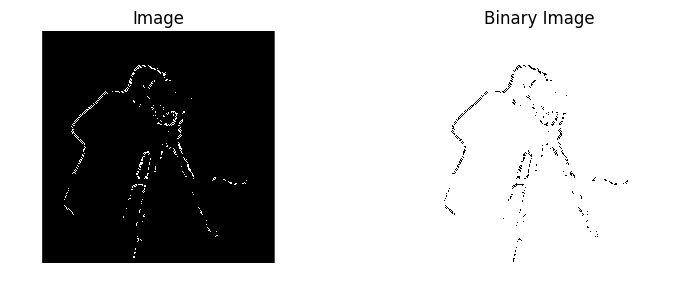

In [6]:
  
def binarize_image_with_double_threshold(magnitude_image, threshold,threshold2):
    binarized_image = np.zeros(magnitude_image.shape)
       
    #binarized_image[magnitude_image>=threshold]=1
    #binarized_image[magnitude_image<=threshold2]=0
    
    for x in range(0, width-1):
        for y in range(0, height-1):
            if(magnitude_image[x][y]<=threshold):
                binarized_image[x][y]=0
            elif(magnitude_image[x][y]>=threshold2):
                binarized_image[x][y]=1
            #else:
                #binarized_image[x][y]=magnitude_image[x][y]
    for x in range(0, width-1):
        for y in range(0, height-1):
            if(binarized_image[x][y]>threshold and binarized_image[x][y]<threshold2 ):
                if((binarized_image[x][y+1] ==1) or (binarized_image[x][y-1] ==1)
                   or (binarized_image[x-1][y-1] ==1) or (binarized_image[x+1][y-1] ==1)
                   or (binarized_image[x-1][y] ==1) or (binarized_image[x+1][y] ==1)
                   or (binarized_image[x-1][y+1] ==1) or (binarized_image[x+1][y+1] ==1)):
                    binarized_image[x][y]==1
                else:
                    binarized_image[x][y]==0
    fig,axes_array=plt.subplots(1, 2)
    fig.set_size_inches(9,3)
    
    image_plot = axes_array[0].imshow(binarized_image,cmap=plt.cm.gray) 
    axes_array[0].axis('off')
    axes_array[0].set(title='Image')   #title
    
    image_plot = axes_array[1].imshow(binarized_image,cmap=plt.cm.binary) 
    axes_array[1].axis('off')
    axes_array[1].set(title='Binary Image')   #title
    #plt.imshow(binarized_image,cmap=plt.cm.gray)
    plt.show()
    
interact(binarize_image_with_double_threshold,magnitude_image=fixed(magnitude_image),
         threshold=FloatSlider(min=0.1, max=1.0, step=0.05,value=0.4,continuous_update=False,description='Threshold'),
        threshold2=FloatSlider(min=0.1, max=1.0, step=0.05,value=0.6,continuous_update=False,description='Threshold2'));